# EFAS - atributos
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 05-08-2023*<br>

**Introducción:**<br>


In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm.notebook import tqdm

from funciones import *

## Configuración

In [3]:
# directorios con los datos de EFAS
path_EFAS = 'C:/Users/jcr693/Documents/EFASv5/'
path_maps = f'{path_EFAS}iberia/maps/'
path_tables = f'{path_EFAS}iberia/tables/'

# directorio con las capas GIS
path_GIS = '../data/GIS/'

# sistema de referencia de coordenadas de todos los datos
crs = 'epsg:4326'

# directorio donde guardar los resultados
path_out = '../data/EFASv5/atributos/'
if os.path.exists(path_out) is False:
    os.mkdir(path_out)

## Subcuencas

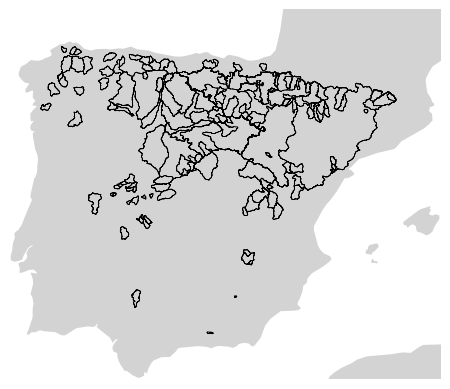

In [4]:
# cargar subcuencas
subcuencas = gpd.read_file(f'{path_GIS}subcuencas_epsg4326.shp')
subcuencas.set_index('gauge_id', drop=False, inplace=True)

# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5);
ax.axis('off');

## Mapas

In [6]:
# cargar mapa de áreas de cada celda, que será utilizado en ciertos cálculos
pixarea = read_static_map(f'{path_maps}pixarea*.nc', var='Band1')

# cargar mapa de áreas de cada celda, que será utilizado en ciertos cálculos
upArea = read_static_map(f'{path_maps}upArea*.nc', var='Band1')

### Geomorfología

In [8]:
maps = {'elv': ['mean', 'std'],
        'gradient': ['mean', 'std'],
        'upArea': ['max'],
        # 'pixarea': ['sum']
       }

# cargar mapas
geomorfologia = xr.Dataset({var: read_static_map(f'{path_maps}{var}_*.nc', var='Band1') for var in maps})
geomorfologia = geomorfologia.drop('crs')

# calcular estadísticos
geomorfologia = geomorfologia.rio.write_crs(crs)
atributos_geomorfologia = polygon_statisctics(geomorfologia, subcuencas, func=maps)

atributos_geomorfologia.head()

  0%|          | 0/162 [00:00<?, ?it/s]

,elv_mean,elv_std,gradient_mean,gradient_std,upArea_max
gauge_id,,,,,
1427,567.753052,193.520554,0.062917,0.046571,714423744.0
1353,1051.484375,294.077667,0.101553,0.071144,525329152.0
1358,1092.863892,408.559784,0.107346,0.072832,394129536.0
1378,569.950989,273.302765,0.078174,0.046319,195347520.0
1343,262.543243,80.161766,0.023155,0.027380,322519072.0


### Usos del suelo 

In [9]:
vars = ['fracforest', 'fracirrigated', 'fracother', 'fracrice', 'fracwater', 'fracsealed']

# cargar mapas
uso_suelo = xr.Dataset({var: read_static_map(f'{path_maps}{var}_*.nc', var='Band1') for var in vars})
uso_suelo = uso_suelo.drop('crs')
uso_suelo = uso_suelo.rename({var: var[4:] for var in list(uso_suelo)})

# multiplicar por el área de cada celda
# uso_suelo *= pixarea

# calcular estadísticos
uso_suelo = uso_suelo.rio.write_crs(crs)
atributos_usos = polygon_statisctics(uso_suelo, subcuencas, func='mean')

atributos_usos.head()

  0%|          | 0/162 [00:00<?, ?it/s]

,forest_mean,irrigated_mean,other_mean,rice_mean,water_mean,sealed_mean
gauge_id,,,,,,
1427,0.636337,0.0,0.360153,0.0,0.000000,0.003510
1353,0.523532,0.0,0.474299,0.0,0.000000,0.002169
1358,0.526812,0.0,0.471456,0.0,0.000895,0.000837
1378,0.580600,0.0,0.414264,0.0,0.000000,0.005137
1343,0.375139,0.0,0.530065,0.0,0.000000,0.094796


### Coeficiente de cultivo

In [10]:
# convertsión de siglas con el uso del suego
mapping_usos = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}

In [12]:
vars = ['cropcoef_f', 'cropcoef_i', 'cropcoef_o']

# cargar mapas
cultivo = xr.Dataset({var: read_static_map(f'{path_maps}{var}_*.nc', var='Band1') for var in vars})
cultivo = cultivo.rename({var: mapping_usos[var.split('_')[1]] for var in list(cultivo)})
# media ponderada por la fracción cubierta por cada uso del suelo
cultivo = cultivo.to_array('land_use').weighted(uso_suelo.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
cultivo = cultivo.where(~upArea.isnull())
cultivo.name = 'cropcoef'
cultivo = cultivo.drop('crs')

# calcular estadísticos
cultivo = cultivo.rio.write_crs(crs)
cultivo = cultivo.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
atributos_cultivo = polygon_statisctics(cultivo, subcuencas, func=['mean', 'std'])

atributos_cultivo.head()

  0%|          | 0/162 [00:00<?, ?it/s]

,cropcoef_mean,cropcoef_std
gauge_id,,
1427,0.928773,0.028341
1353,0.934876,0.025176
1358,0.937140,0.019032
1378,0.905903,0.046539
1343,0.786850,0.116726


  0%|          | 0/162 [00:00<?, ?it/s]

,chanbnkf_mean,chanbw_mean,changrad_mean,chanlength_sum,chanman_mean
gauge_id,,,,,
1427,1.602375,0.0,0.028964,83310.398438,0.035686
1353,1.301466,0.0,0.037568,64654.187500,0.043118
1358,1.613151,0.0,0.035102,47311.312500,0.038191
1378,1.303149,0.0,0.028198,13783.006836,0.036062
1343,1.438849,0.0,0.007459,37708.382812,0.033606


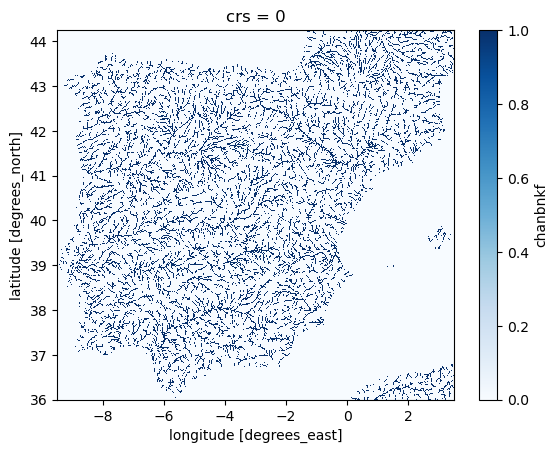

In [14]:
### Cauces


maps = {'chanbnkf': ['mean'],
        'chanbw': ['mean'],
        'changrad': ['mean'],
        'chanlength': ['sum'],
        'chanman': ['mean']}

# cargar y reordenar los mapas
cauces = {var: read_static_map(f'{path_maps}{var}_*.nc', var='Band1') for var in maps}
cauces = {var: da.rename(var) for var, da in cauces.items()}
cauces = {var : da.drop([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in cauces.items()}
cauces = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in cauces.items()})

# enmascarar los cauces (celdas con calado mayor de 1 m)
rios = cauces['chanbnkf'] > 1
rios.plot(cmap='Blues')
cauces = cauces.where(rios)

# calcular estadístico
cauces = cauces.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
cauces = cauces.rio.write_crs(crs)
atributos_cauces = polygon_statisctics(cauces, subcuencas, func=maps)

atributos_cauces.head()

### Suelos 

In [ ]:
vars = ['ksat', 'lambda', 'genua', 'soildepth', 'thetas', 'thetar']
layers = [1, 2, 3]
maps = [f'{var}{layer}' for var in vars for layer in layers]

# cargar mapas
suelos = {}
for var in tqdm(maps):
    files = glob.glob(f'{path_maps}{var}_*.nc')
    if len(files) > 1:
        ds = {}
        for file in files:
            # tipo de cobertura del suelo
            cover = mapping_usos[file.split('\\')[1].split('_')[1]]
            # importar datos
            ds[cover] = read_static_map(file)
        ds = xr.Dataset(ds)
        da = ds.to_array('land_use').weighted(uso_suelo.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
        da = da.drop('crs')
        suelos[var] = da.where(~upArea.isnull())
    elif len(files) == 1:
        suelos[var] = read_static_map(files[0])
suelos = xr.Dataset(suelos)
suelos = suelos.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
# suelos = suelos.drop('crs')

# calcular estadístico
suelos = suelos.rio.write_crs(crs)
atributos_suelos = polygon_statisctics(suelos, subcuencas, func='mean')

atributos_suelos.head()

### Índice foliar

El dato original de índice foliar (_leaf area index_, LAI) es una serie con frecuencia 10 días que representa la fenología de cada uso del suelo a lo largo de un año tipo. Puesto que la idea original del LST es que los únicos datos dinámicos sean los forzamientos meteorológicos, convertiré esta serie semanal en un dato medio anual

In [24]:
maps = ['lai_f', 'lai_i', 'lai_o']

# cargar mapas
lai = xr.Dataset({var: read_static_map(f'{path_maps}{var}_*.nc', var='Band1') for var in maps})
lai = lai.rename({var: mapping_usos[var.split('_')[1]] for var in list(lai)})
lai = lai.drop('crs')

# media ponderada por la fracción cubierta por cada uso del suelo
lai = lai.to_array('land_use').weighted(uso_suelo.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
lai = lai.where(~upArea.isnull())
lai.name = 'lai'
lai = lai.drop('crs')

# media temporal
lai = lai.mean('time')

# calcular estadístico
lai = lai.rio.write_crs(crs)
atributos_lai = polygon_statisctics(lai, subcuencas, func='mean')

atributos_lai.head()

  0%|          | 0/162 [00:00<?, ?it/s]

,lai_mean
gauge_id,
1427,2.835848
1353,2.149170
1358,2.080862
1378,2.699044
1343,2.377050


### Demandas

Los datos originales de demanda contienen mapas con la serie mensual de demandas (doméstica, energética, industrical y ganadera) en mm/día. Los mapas abarcan el periodo 1990-2023, con la idea de tener en cuenta el carácter cambiante de la demanda no sólo en el ciclo anual, sino también con el paso de los años.

Al igual que en el caso del LAI, calcularé una media anual para convertir estos atributos en estáticos. Convertiré la demanda en mm/dia en volumen multiplicando cada celda por su área.

In [25]:
maps = ['dom', 'ene', 'ind', 'liv']

# cargar mapas
demanda = xr.Dataset({var: read_static_map(f'{path_maps}{var}_*.nc', var=var) for var in maps})
demanda = demanda.drop('wgs_1984')

# media temporal
demanda = demanda.mean('time')

# calcular volumen
demanda = demanda * 1e-3 * pixarea

# calcular estadístico
demanda = demanda.rio.write_crs(crs)
atributos_demanda = polygon_statisctics(demanda, subcuencas, func='sum')

atributos_demanda.head()

  0%|          | 0/162 [00:00<?, ?it/s]

,dom_sum,ene_sum,ind_sum,liv_sum
gauge_id,,,,
1427,347.288116,0.00000,0.000000,6615.734863
1353,706.102844,0.00000,602.269653,1153.776245
1358,0.000000,0.00000,167.999954,1158.059326
1378,562.988647,0.00000,849.524902,1600.042236
1343,28804.898438,51816.53125,37167.710938,2564.738525


### Embalses

EFAS representa 334 embalses en la zona de estudio


  0%|          | 0/162 [00:00<?, ?it/s]

,tstor_sum,tstor_count
gauge_id,,
1427,0.0,0.0
1353,0.0,0.0
1358,0.0,0.0
1378,0.0,0.0
1343,0.0,0.0


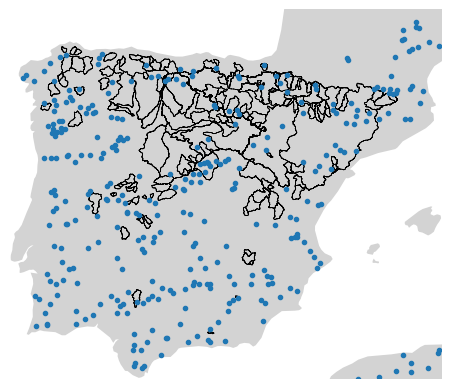

In [34]:
# cargar mapa
var = 'res'
da = read_static_map(f'{path_maps}{var}_*.nc', var=var)

# extraer ID de los embalses
ids = np.unique(da)
ids = ids[~np.isnan(ids)]
print('EFAS representa {0} embalses en la zona de estudio'.format(len(ids)))

# cargar metadatos de los embalses
embalses = pd.read_csv(f'{path_tables}EFAS_HRES_reservoirs_metadata.csv')
embalses.set_index('ResID', inplace=True)

# recortar a los IDs que hay en el mapa
embalses = embalses.loc[ids, :]

# convertir en geopandas.GeoDataFrame
embalses = gpd.GeoDataFrame(embalses, geometry=[Point(xy) for xy in zip(embalses.LisfloodX, embalses.LisfloodY)])
embalses.crs = crs

# añadir atributos desde las tablas utilizadas LISFLOOD
for file in glob.glob(f'{path_tables}r*.txt'):
    var = file.split('\\')[-1].split('.')[0][1:]
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['ResID', var]
        df.set_index('ResID', inplace=True, drop=True)
        embalses[var] = df
    except:
        print(file)
        continue

# plot embalses
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5)
embalses.plot(ax=ax, marker='.')
ax.axis('off');

# calcular estadístico
atributos_embalses = point_polygon_statisctics(embalses, subcuencas, func = {'tstor': ['sum', 'count']})
atributos_embalses.dropna(axis=1, how='all', inplace=True)
atributos_embalses.replace(np.nan, 0, inplace=True)

atributos_embalses.head()

### Lagos

EFAS representa 8 lagos en la zona de estudio.


  0%|          | 0/162 [00:00<?, ?it/s]

,area_sum,area_count
gauge_id,,
1427,0.0,0.0
1353,0.0,0.0
1358,0.0,0.0
1378,0.0,0.0
1343,0.0,0.0


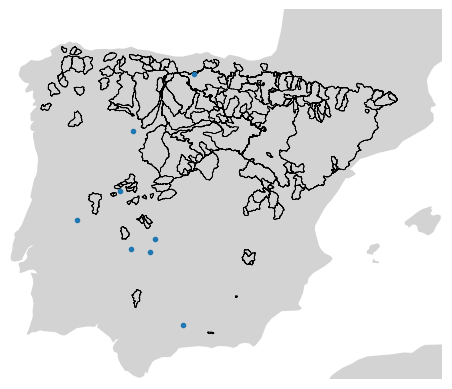

In [50]:
# cargar mapa
var = 'lakes'
da = read_static_map(f'{path_maps}{var}_*.nc', var=var)

# extraer ID de los embalses
ids = np.unique(da)
ids = ids[~np.isnan(ids)]
print('EFAS representa {0} lagos en la zona de estudio.'.format(len(ids)))

# cargar metadatos de los lagos
lagos = pd.read_csv(f'{path_tables}EFAS_HRES_lakes_metadata.csv')
lagos.set_index('LakID', inplace=True)

# recortar a los IDs que hay en el mapa
lagos = lagos.loc[ids, :]

# convertir en geopandas.GeoDataFrame
lagos = gpd.GeoDataFrame(lagos, geometry=[Point(xy) for xy in zip(lagos.LisfloodX, lagos.LisfloodY)])
lagos.crs = crs

# añadir atributos desde las tablas utilizadas LISFLOOD
for file in glob.glob(f'{path_tables}lake*.txt'):
    var = file.split('\\')[-1].split('.')[0][4:]
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['ResID', var]
        df.set_index('ResID', inplace=True, drop=True)
        lagos[var] = df
    except:
        print(file)
        continue

# plot embalses
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.5)
lagos.plot(ax=ax, marker='.')
ax.axis('off');

# calcular estadístico
atributos_lagos = point_polygon_statisctics(lagos, subcuencas, func={'area': ['sum', 'count']})
atributos_lagos.dropna(axis=1, how='all', inplace=True)
atributos_lagos.replace(np.nan, 0, inplace=True)

atributos_lagos.head()

## Exportar

In [51]:
atrs = pd.concat((atributos_geomorfologia,
                  atributos_cauces,
                  atributos_cultivo,
                  atributos_demanda,
                  atributos_embalses,
                  atributos_lagos,
                  atributos_lai,
                  atributos_suelos,
                  atributos_usos), axis=1)

print('{0} atributos definen las características de las {1} subcuencas'.format(*atrs.shape[::-1]))

atrs.to_csv(f'{path_out}atributos_subcuencas.csv')

45 atributos definen las características de las 162 subcuencas
